In [1]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# AON TEAM: CBU Coding Challenge - EDA & Feature Selection Pipeline
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# ==============================================================================
# 0. ПОДГОТОВКА СРЕДЫ
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xml.etree.ElementTree as ET
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

print("✅ Среда подготовлена.")


✅ Среда подготовлена.


In [3]:
# ==============================================================================
# 1. ЗАГРУЗКА И ПАРСИНГ ДАННЫХ
# ==============================================================================
drive.mount('/content/drive', force_remount=True)
DATA_PATH = '/content/drive/MyDrive/DATA for CBU'

def load_xml_iteratively(xml_path):
    records = []
    for event, elem in ET.iterparse(xml_path, events=('end',)):
        if elem.tag == 'record':
            data = {child.tag: child.text for child in elem}
            records.append(data)
            elem.clear()
    return pd.DataFrame(records)

def load_all_data(path):
    dataframes = {}
    files_info = {
        'loan_details.xlsx': pd.read_excel, 'demographics.csv': pd.read_csv,
        'application_metadata.csv': pd.read_csv, 'credit_history.parquet': pd.read_parquet,
        'geographic_data.xml': load_xml_iteratively,
        'financial_ratios.jsonl': lambda p: pd.read_json(p, lines=True)
    }
    print("--- 🚀 Начало загрузки данных ---")
    for fname, loader_func in files_info.items():
        file_path = os.path.join(path, fname)
        df_name = fname.split('.')[0]
        try:
            dataframes[df_name] = loader_func(file_path)
            print(f"✅ Файл '{fname}' загружен. Форма: {dataframes[df_name].shape}")
        except Exception as e:
            print(f"❌ Ошибка при загрузке '{fname}': {e}")
            dataframes[df_name] = pd.DataFrame()
    return dataframes

dataframes = load_all_data(DATA_PATH)

Mounted at /content/drive
--- 🚀 Начало загрузки данных ---
✅ Файл 'loan_details.xlsx' загружен. Форма: (89999, 10)
✅ Файл 'demographics.csv' загружен. Форма: (89999, 8)
✅ Файл 'application_metadata.csv' загружен. Форма: (89999, 14)
✅ Файл 'credit_history.parquet' загружен. Форма: (89999, 12)
✅ Файл 'geographic_data.xml' загружен. Форма: (0, 0)
✅ Файл 'financial_ratios.jsonl' загружен. Форма: (89999, 16)


In [4]:
# ==============================================================================
# 2. ПАЙПЛАЙН ОБЪЕДИНЕНИЯ ДАННЫХ
# ==============================================================================
def merge_dataframes(dfs):
    print("\n--- 🚀 Начало объединения данных ---")
    key_map = {'loan_details': 'customer_id', 'demographics': 'cust_id', 'application_metadata': 'customer_ref', 'credit_history': 'customer_number', 'financial_ratios': 'cust_num', 'geographic_data': 'customer'}
    for name, df in dfs.items():
        if name in key_map and key_map[name] in df.columns:
            df.rename(columns={key_map[name]: 'customer_id'}, inplace=True)
    if 'default' not in dfs['application_metadata'].columns: raise ValueError("Целевая переменная 'default' не найдена!")
    master_df = dfs['application_metadata'].copy()
    for name, df in dfs.items():
        if name != 'application_metadata' and 'customer_id' in df.columns:
            master_df = pd.merge(master_df, df, on='customer_id', how='left')
    master_df['customer_id'] = pd.to_numeric(master_df['customer_id'], errors='coerce')
    master_df.sort_values('customer_id', inplace=True)
    print(f"\n✅ Объединение завершено. Итоговая форма: {master_df.shape}")
    return master_df

master_df = merge_dataframes(dataframes)


--- 🚀 Начало объединения данных ---

✅ Объединение завершено. Итоговая форма: (89999, 56)


In [5]:
# ==============================================================================
# 3.ПАЙПЛАЙН ОЧИСТКИ (ОБЕЗВРЕЖИВАНИЕ "МИН")
# ==============================================================================
def full_cleaning_pipeline(df):
    print("\n--- 🚀 Начало полного пайплайна очистки и трансформации ---")
    df_clean = df.copy()

    print("  - Обезвреживание 'мин' в числовых столбцах...")
    dirty_numeric_cols = ['loan_amount', 'annual_income', 'monthly_income', 'existing_monthly_debt', 'monthly_payment', 'revolving_balance', 'credit_usage_amount', 'available_credit', 'total_monthly_debt_payment', 'total_debt_amount', 'monthly_free_cash_flow']
    for col in dirty_numeric_cols:
        if col in df_clean.columns: df_clean[col] = pd.to_numeric(df_clean[col].astype(str).str.replace(r'[^\d.-]', '', regex=True), errors='coerce')

    print("  - Обезвреживание 'мин' в 'employment_type'...")
    if 'employment_type' in df_clean.columns:
        emp_map = {'full-time': 'full_time', 'full time': 'full_time', 'ft': 'full_time', 'part-time': 'part_time', 'part time': 'part_time', 'pt': 'part_time', 'self-employed': 'self_employed', 'self emp': 'self_employed', 'contractor': 'contractor'}
        df_clean['employment_type'] = df_clean['employment_type'].str.lower().str.strip().map(emp_map).fillna('other')

    print("  - Обезвреживание 'мин' в 'loan_type' и 'loan_purpose'...")
    if 'loan_type' in df_clean.columns and 'loan_purpose' in df_clean.columns:
        def map_loan_category(row):
            type_val, purpose_val = str(row.get('loan_type', '')).lower().strip(), str(row.get('loan_purpose', '')).lower().strip()
            if 'home' in purpose_val or 'mortgage' in type_val: return 'home_loan'
            if 'refinance' in purpose_val: return 'refinance'
            if 'credit' in purpose_val or 'card' in type_val: return 'credit_card'
            if 'personal' in type_val: return 'personal_loan'
            if 'medical' in purpose_val: return 'medical'
            if 'debt consolidation' in purpose_val: return 'debt_consolidation'
            if 'purchase' in purpose_val: return 'major_purchase'
            return 'other'
        df_clean['loan_category'] = df_clean.apply(map_loan_category, axis=1)
        df_clean.drop(columns=['loan_type', 'loan_purpose'], inplace=True)

    print("  - Умная обработка пропусков...")
    if 'employment_length' in df_clean.columns:
        df_clean['is_employed'] = np.where(df_clean['employment_length'].isnull(), 0, 1)
        df_clean['employment_length'].fillna(0, inplace=True)
    if 'num_delinquencies_2yrs' in df_clean.columns:
        df_clean['num_delinquencies_2yrs'].fillna(0, inplace=True)
    if 'revolving_balance' in df_clean.columns:
        df_clean['has_revolving_credit'] = np.where(df_clean['revolving_balance'].isnull(), 0, 1)
        df_clean['revolving_balance'].fillna(0, inplace=True)

    print("\n✅ Полная очистка завершена. Все 'мины' обезврежены.")
    return df_clean

master_df_clean = full_cleaning_pipeline(master_df)


--- 🚀 Начало полного пайплайна очистки и трансформации ---
  - Обезвреживание 'мин' в числовых столбцах...
  - Обезвреживание 'мин' в 'employment_type'...
  - Обезвреживание 'мин' в 'loan_type' и 'loan_purpose'...
  - Умная обработка пропусков...

✅ Полная очистка завершена. Все 'мины' обезврежены.



--- 🚀 Анализ важности ВСЕХ признаков (IV) для 'default' ---
Обработка категориальных признаков...
Обработка числовых признаков (с бинингом)...


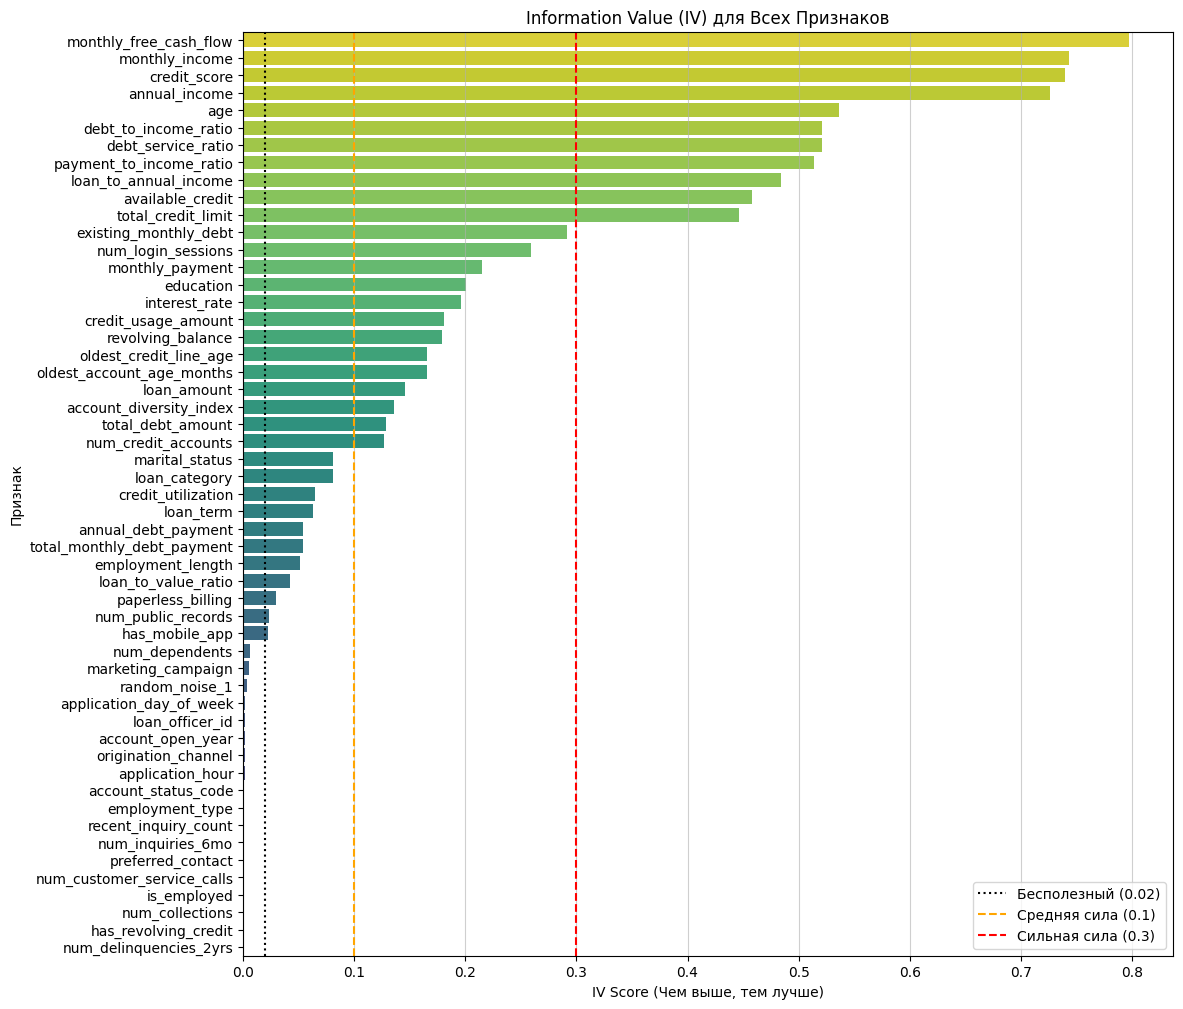


Таблица IV Scores для ВСЕХ признаков:


,IV
monthly_free_cash_flow,0.797277
monthly_income,0.743174
credit_score,0.740082
annual_income,0.725949
age,0.536309
debt_to_income_ratio,0.521427
debt_service_ratio,0.521260
payment_to_income_ratio,0.513952
loan_to_annual_income,0.484323
available_credit,0.458422


In [6]:
# ==============================================================================
# 4. АНАЛИЗ ВАЖНОСТИ ВСЕХ ПРИЗНАКОВ (IV)
# ==============================================================================
def calculate_iv(df, feature, target):
    feature_series = df[feature].fillna('Missing')
    lst = []
    for val in feature_series.unique():
        all_count, good_count, bad_count = df[feature_series == val].shape[0], df[(feature_series == val) & (df[target] == 0)].shape[0], df[(feature_series == val) & (df[target] == 1)].shape[0]
        lst.append([feature, val, all_count, good_count, bad_count])
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad']).replace({'Good': {0: 1e-5}, 'Bad': {0: 1e-5}})
    total_good, total_bad = data['Good'].sum(), data['Bad'].sum()
    data['Distribution Good'], data['Distribution Bad'] = data['Good'] / total_good, data['Bad'] / total_bad
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])
    return data['IV'].sum()

def analyze_feature_importance_full(df, target, num_bins=10):
    print(f"\n--- 🚀 Анализ важности ВСЕХ признаков (IV) для '{target}' ---")
    df_temp, iv_dict = df.copy(), {}
    cat_cols, num_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist(), df_temp.select_dtypes(include=np.number).columns.tolist()
    id_cols = ['customer_id', 'application_id']
    num_cols = [col for col in num_cols if col not in id_cols + [target]]
    print("Обработка категориальных признаков...")
    for col in cat_cols:
        if df_temp[col].nunique() < 100: iv_dict[col] = calculate_iv(df_temp, col, target)
    print("Обработка числовых признаков (с бинингом)...")
    for col in num_cols:
        if df_temp[col].nunique() <= 2: iv_dict[col] = calculate_iv(df_temp, col, target); continue
        try:
            df_temp[f"{col}_binned"] = pd.qcut(df_temp[col], q=num_bins, duplicates='drop', labels=False)
            iv_dict[col] = calculate_iv(df_temp, f"{col}_binned", target)
        except Exception as e: print(f"  - Не удалось обработать '{col}': {e}")
    iv_df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=['IV']).sort_values('IV', ascending=False)
    plt.figure(figsize=(12, 12)); sns.barplot(x=iv_df['IV'], y=iv_df.index, palette='viridis_r'); plt.title('Information Value (IV) для Всех Признаков'); plt.xlabel('IV Score (Чем выше, тем лучше)'); plt.ylabel('Признак'); plt.axvline(x=0.02, color='black', linestyle=':', label='Бесполезный (0.02)'); plt.axvline(x=0.1, color='orange', linestyle='--', label='Средняя сила (0.1)'); plt.axvline(x=0.3, color='red', linestyle='--', label='Сильная сила (0.3)'); plt.grid(axis='x', alpha=0.6); plt.legend(); plt.show()
    return iv_df

iv_results_full = analyze_feature_importance_full(master_df_clean, 'default')
print("\nТаблица IV Scores для ВСЕХ признаков:")
display(iv_results_full)

In [7]:
# ==============================================================================
# 5. АВТОМАТИЧЕСКИЙ ОТБОР ПРИЗНАКОВ (FEATURE SELECTION)
# ==============================================================================
def select_features_by_iv(df, iv_df, min_iv_threshold=0.02, top_n=40):
    print("\n--- 🚀 Начало отбора признаков по IV ---")
    powerful_features_df = iv_df[iv_df['IV'] >= min_iv_threshold]
    top_features_df = powerful_features_df.head(top_n)
    selected_features = top_features_df.index.tolist()
    essential_cols = [col for col in ['customer_id', 'application_id', 'default'] if col in df.columns]
    final_cols = essential_cols + selected_features
    final_cols = [col for col in final_cols if col in df.columns]
    final_df = df[final_cols]
    print(f"Отбор завершен. Порог IV > {min_iv_threshold}, максимум {top_n} признаков.")
    print(f"Исходное количество признаков: {len(df.columns)}")
    print(f"Итоговое количество признаков: {len(final_df.columns)}")
    print(f"\nОставленные предикторы ({len(selected_features)} шт.):\n{selected_features}")
    return final_df

final_dataset = select_features_by_iv(master_df_clean, iv_results_full, top_n=35)


--- 🚀 Начало отбора признаков по IV ---
Отбор завершен. Порог IV > 0.02, максимум 35 признаков.
Исходное количество признаков: 57
Итоговое количество признаков: 38

Оставленные предикторы (35 шт.):
['monthly_free_cash_flow', 'monthly_income', 'credit_score', 'annual_income', 'age', 'debt_to_income_ratio', 'debt_service_ratio', 'payment_to_income_ratio', 'loan_to_annual_income', 'available_credit', 'total_credit_limit', 'existing_monthly_debt', 'num_login_sessions', 'monthly_payment', 'education', 'interest_rate', 'credit_usage_amount', 'revolving_balance', 'oldest_credit_line_age', 'oldest_account_age_months', 'loan_amount', 'account_diversity_index', 'total_debt_amount', 'num_credit_accounts', 'marital_status', 'loan_category', 'credit_utilization', 'loan_term', 'annual_debt_payment', 'total_monthly_debt_payment', 'employment_length', 'loan_to_value_ratio', 'paperless_billing', 'num_public_records', 'has_mobile_app']


In [9]:
# ==============================================================================
# 6. ФИНАЛИЗАЦИЯ И СОХРАНЕНИЕ
# ==============================================================================
print("\n--- 🚀 Финализация и сохранение ---")
print("\nИтоговая информация о датасете 'alldata.csv' ПОСЛЕ ОТБОРА ПРИЗНАКОВ:")
final_dataset.info()
output_path = os.path.join(DATA_PATH, 'alldata.csv')
final_dataset.to_csv(output_path, index=False)
print(f"\n✅ Идеальный EDA завершен! Финальный датасет с лучшими признаками сохранен: '{output_path}'")


--- 🚀 Финализация и сохранение ---

Итоговая информация о датасете 'alldata.csv' ПОСЛЕ ОТБОРА ПРИЗНАКОВ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89999 entries, 0 to 89998
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 89999 non-null  int64  
 1   application_id              89999 non-null  int64  
 2   default                     89999 non-null  int64  
 3   monthly_free_cash_flow      89999 non-null  float64
 4   monthly_income              89999 non-null  float64
 5   credit_score                89999 non-null  int64  
 6   annual_income               89999 non-null  int64  
 7   age                         89999 non-null  int64  
 8   debt_to_income_ratio        89999 non-null  float64
 9   debt_service_ratio          89999 non-null  float64
 10  payment_to_income_ratio     89999 non-null  float64
 11  loan_to_annual_income       89999 non-n